In [1]:
# Notebook cell
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

%matplotlib inline
sns.set_theme(style='whitegrid')

db_dir = Path("meltano-ingestion/db")  # or Path("db") depending on your project
csv_files = list(db_dir.glob("*.csv"))

In [9]:
# Load order_prod_time_price_citystate data
df_order_price = pd.read_csv(db_dir / "order_prod_time_price_citystate.csv")
print(f"Dataset shape: {df_order_price.shape}")
df_order_price.head()

Dataset shape: (112650, 11)


,order_id,product_id,price,product_category_name_english,order_purchase_timestamp,order_purchase_date,day_of_week,time_of_day,order_purchase_time,customer_city,customer_state
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,58.90,cool_stuff,2017-09-13 08:59:02,2017-09-13,Wednesday,Morn,08:59:02,campos dos goytacazes,RJ
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,239.90,pet_shop,2017-04-26 10:53:06,2017-04-26,Wednesday,Morn,10:53:06,santa fe do sul,SP
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,199.00,furniture_decor,2018-01-14 14:33:31,2018-01-14,Sunday,Aftern,14:33:31,para de minas,MG
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,12.99,perfumery,2018-08-08 10:00:35,2018-08-08,Wednesday,Morn,10:00:35,atibaia,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,199.90,garden_tools,2017-02-04 13:57:51,2017-02-04,Saturday,Lunch,13:57:51,varzea paulista,SP


When we tried to do a direct frequency distribution plot, we realised that the data was skewed by outliers sprinkled above $400 mark. We now explore the data by splitting them at the $400 price point. First, those <= $400. 

In [10]:
# Filter for prices <= 400
df_price_filtered = df_order_price[df_order_price['price'] <= 400]
print(f"Original records: {len(df_order_price)}")
print(f"Filtered records (price <= 400): {len(df_price_filtered)}")
print(f"Removed records: {len(df_order_price) - len(df_price_filtered)}")

Original records: 112650
Filtered records (price <= 400): 108411
Removed records: 4239


Plot bar chart for those <= $400.

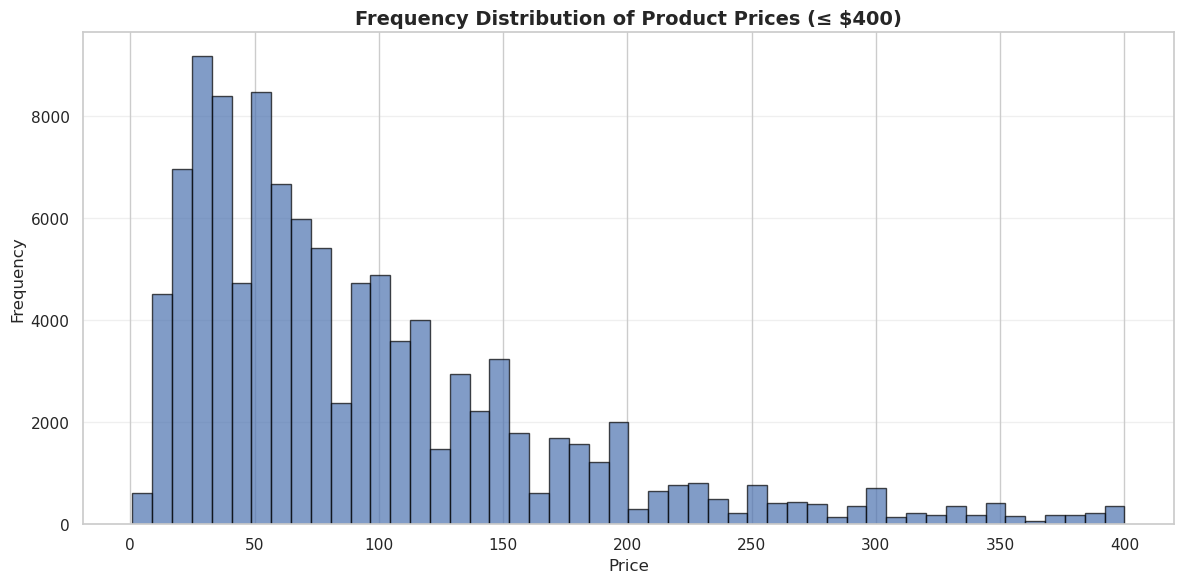


Price Statistics (for prices ≤ 400):
count    108411.000000
mean         93.555754
std          75.090847
min           0.850000
25%          39.600000
50%          69.900000
75%         124.990000
max         400.000000
Name: price, dtype: float64


In [11]:
# Plot frequency distribution for price
plt.figure(figsize=(12, 6))
plt.hist(df_price_filtered['price'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Frequency Distribution of Product Prices (≤ $400)', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Display statistics
print("\nPrice Statistics (for prices ≤ 400):")
print(df_price_filtered['price'].describe())

Get a sense of how much each of the 2 product price range orders contributes to the total transactions.

In [12]:
# Calculate price totals for rows with price > 400 and price <= 400
price_total_above_400 = df_order_price[df_order_price['price'] > 400]['price'].sum()
price_total_at_or_below_400 = df_order_price[df_order_price['price'] <= 400]['price'].sum()

print("Price Totals:")
print(f"  Total price for rows with price > $400:  ${price_total_above_400:,.2f}")
print(f"  Total price for rows with price <= $400: ${price_total_at_or_below_400:,.2f}")
print(f"  Grand total (all rows):                  ${df_order_price['price'].sum():,.2f}")
print(f"\nPercentage breakdown:")
print(f"  Price > $400:  {(price_total_above_400 / df_order_price['price'].sum() * 100):.2f}%")
print(f"  Price <= $400: {(price_total_at_or_below_400 / df_order_price['price'].sum() * 100):.2f}%")

Price Totals:
  Total price for rows with price > $400:  $3,449,170.89
  Total price for rows with price <= $400: $10,142,472.81
  Grand total (all rows):                  $13,591,643.70

Percentage breakdown:
  Price > $400:  25.38%
  Price <= $400: 74.62%


The following few steps plots the Top 10 product categories for orders for product price > $400 with labels indicating the median. 

In [22]:
# Filter for price > 400
df_above_400 = df_order_price[df_order_price['price'] > 400]

# Check if product_category column exists, and show available columns
print(f"Number of rows with price > 400: {len(df_above_400)}")
print(f"\nAvailable columns: {df_above_400.columns.tolist()}")
df_above_400.head()

Number of rows with price > 400: 4239

Available columns: ['order_id', 'product_id', 'price', 'product_category_name_english', 'order_purchase_timestamp', 'order_purchase_date', 'day_of_week', 'time_of_day', 'order_purchase_time', 'customer_city', 'customer_state']


,order_id,product_id,price,product_category_name_english,order_purchase_timestamp,order_purchase_date,day_of_week,time_of_day,order_purchase_time,customer_city,customer_state
7,000576fe39319847cbb9d288c5617fa6,557d850972a7d6f792fd18ae1400d9b6,810.00,garden_tools,2018-07-04 12:08:27,2018-07-04,Wednesday,Lunch,12:08:27,praia grande,SP
16,0009c9a17f916a706d71784483a5d643,3f27ac8e699df3d300ec4a5d8c5cf0b2,639.00,consoles_games,2018-04-25 09:10:41,2018-04-25,Wednesday,Morn,09:10:41,campinas,SP
39,0017afd5076e074a48f1f1a4c7bac9c5,fe59a1e006df3ac42bf0ceb876d70969,809.10,computers_accessories,2017-04-06 22:16:10,2017-04-06,Thursday,Eveng,22:16:10,campo alegre,AL
70,0029c5db35ef291ce99d1262012e7daa,7614c62b86a81021243e438cfde78ccc,492.75,health_beauty,2018-08-25 00:09:40,2018-08-25,Saturday,Wee,00:09:40,guarulhos,SP
158,006127b8b9a1681a982313ed7129c3c0,f819f0c84a64f02d3a5606ca95edd272,540.00,watches_gifts,2018-03-08 16:01:59,2018-03-08,Thursday,Aftern,16:01:59,sao paulo,SP


In [23]:
# Group by product category and calculate count and median price
category_stats_400 = df_above_400.groupby('product_category_name_english').agg(
    count=('price', 'size'),
    median_price=('price', 'median')
).sort_values('count', ascending=False).reset_index()

# Get top 10 categories
top10_categories = category_stats_400.head(10)

print("Top 10 Product Categories (Price > $400):")
print(top10_categories.to_string(index=False))

Top 10 Product Categories (Price > $400):
product_category_name_english  count  median_price
                watches_gifts    640       679.000
                health_beauty    490       598.395
                   cool_stuff    247       610.000
                         auto    241       589.000
               sports_leisure    205       659.000
        computers_accessories    202       700.400
                    computers    202      1100.000
                 garden_tools    162       615.000
                         baby    142       889.000
                         toys    135       599.900


Plot bar chart for top 10 product categories for product price > $400.

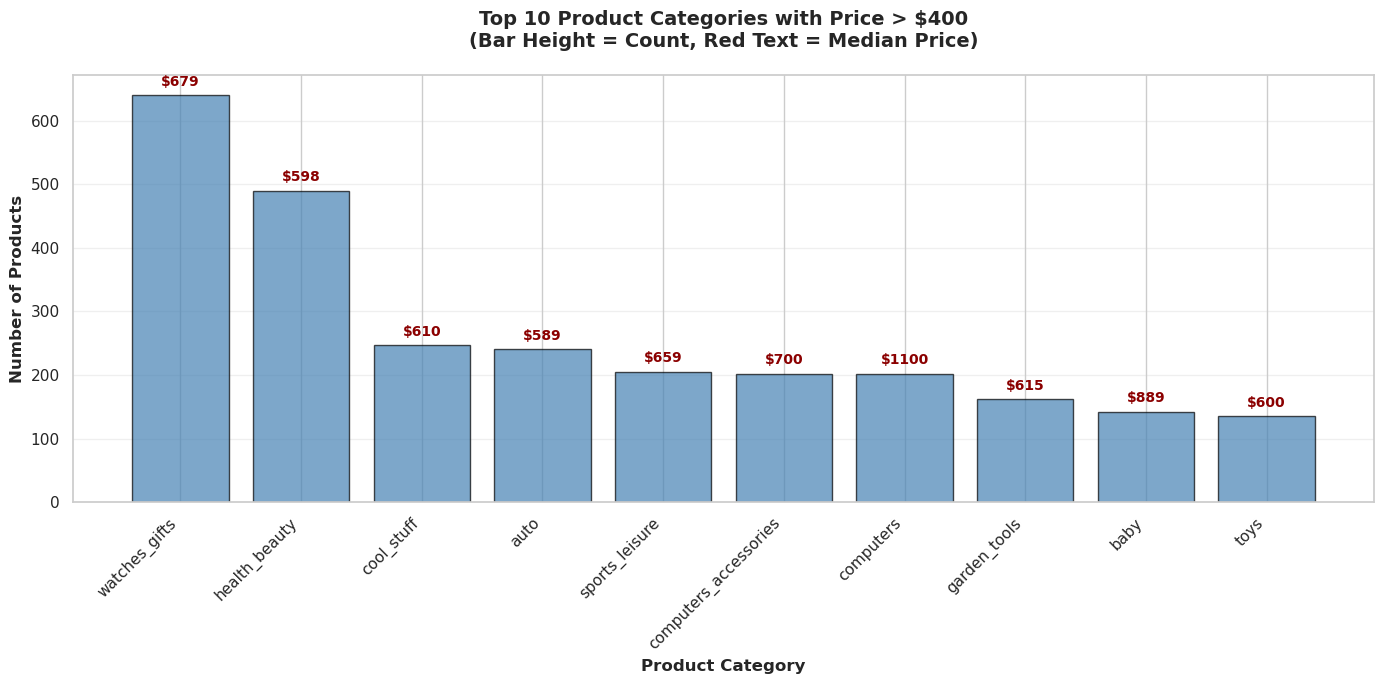

In [24]:
# Create bar chart with dual information: count (bar height) and median price (color/annotation)
fig, ax = plt.subplots(figsize=(14, 7))

# Create bars for count
bars = ax.bar(range(len(top10_categories)), 
               top10_categories['count'], 
               color='steelblue', 
               alpha=0.7,
               edgecolor='black')

# Add median price annotations on top of each bar
for i, row in top10_categories.iterrows():
    ax.text(i, row['count'] + 10, 
            f"${row['median_price']:.0f}", 
            ha='center', 
            va='bottom',
            fontsize=10,
            fontweight='bold',
            color='darkred')

# Formatting
ax.set_xlabel('Product Category', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Products', fontsize=12, fontweight='bold')
ax.set_title('Top 10 Product Categories with Price > $400\n(Bar Height = Count, Red Text = Median Price)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(range(len(top10_categories)))
ax.set_xticklabels(top10_categories['product_category_name_english'], rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

The following few steps plots the Top 10 product categories for orders for product price <=> $400 with labels indicating the median. 

In [25]:
# Group by product category for price <= 400 and calculate count and median price
category_stats = df_price_filtered.groupby('product_category_name_english').agg(
    count=('price', 'size'),
    median_price=('price', 'median')
).sort_values('count', ascending=False).reset_index()

# Get top 10 categories
top10_categories_400_or_less = category_stats.head(10)

print("Top 10 Product Categories (Price <= $400):")
print(top10_categories_400_or_less.to_string(index=False))

Top 10 Product Categories (Price <= $400):
product_category_name_english  count  median_price
               bed_bath_table  11040        78.990
                health_beauty   9180        72.945
               sports_leisure   8436        74.990
              furniture_decor   8278        65.000
        computers_accessories   7625        79.900
                   housewares   6854        58.900
                watches_gifts   5351       115.000
                    telephony   4463        29.980
                 garden_tools   4185        59.900
                         auto   3994        74.900


Plot bar chart for top 10 product categories for product price <= $400.

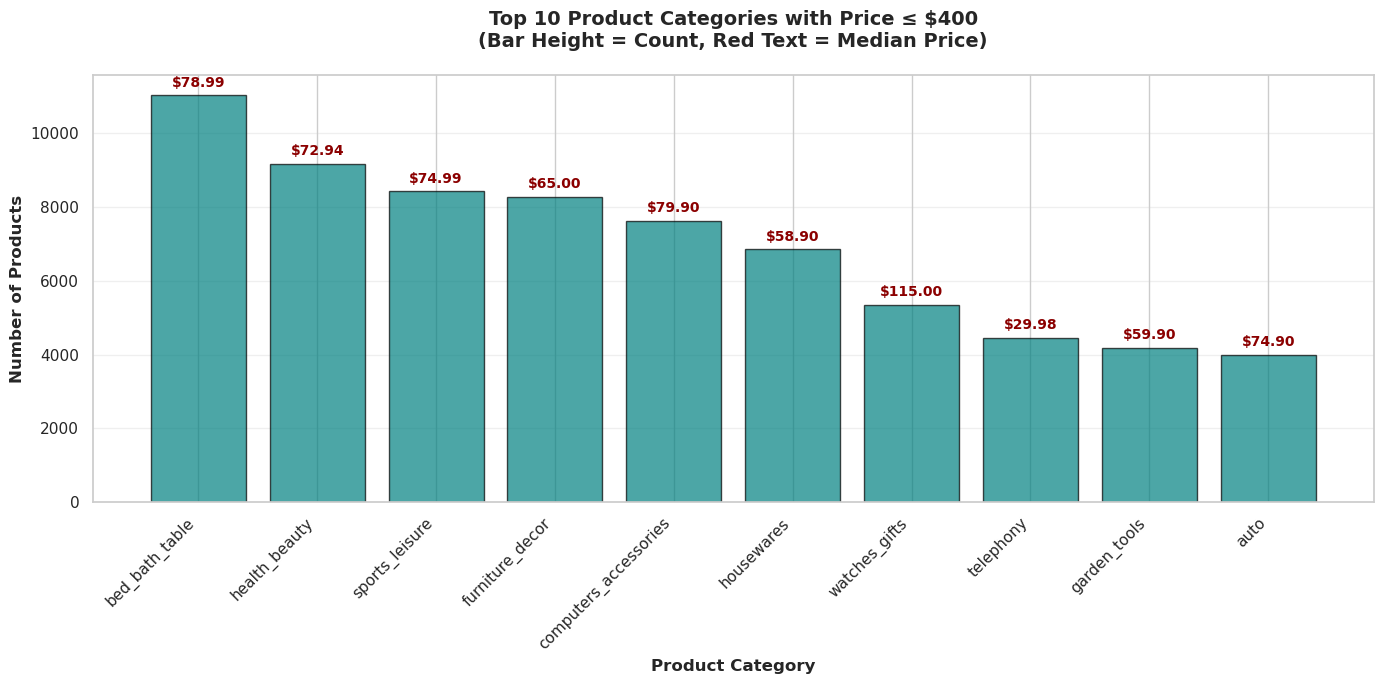

In [26]:
# Create bar chart for products with price <= 400
fig, ax = plt.subplots(figsize=(14, 7))

# Create bars for count
bars = ax.bar(range(len(top10_categories_400_or_less)), 
               top10_categories_400_or_less['count'], 
               color='teal', 
               alpha=0.7,
               edgecolor='black')

# Add median price annotations on top of each bar
for i, row in top10_categories_400_or_less.iterrows():
    ax.text(i, row['count'] + 150, 
            f"${row['median_price']:.2f}", 
            ha='center', 
            va='bottom',
            fontsize=10,
            fontweight='bold',
            color='darkred')

# Formatting
ax.set_xlabel('Product Category', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Products', fontsize=12, fontweight='bold')
ax.set_title('Top 10 Product Categories with Price ≤ $400\n(Bar Height = Count, Red Text = Median Price)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(range(len(top10_categories_400_or_less)))
ax.set_xticklabels(top10_categories_400_or_less['product_category_name_english'], rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

Based on the top categories of both product price ranges, we observed that there are 7 top product categories common between them, in fact contributes to 40% of the total order value (used a simple calculator for this)! So we dwelled deeper by first producing the niche-list.

In [27]:
# Create niche_list table with selected product categories
niche_categories = [
    'bed_bath_table',
    'health_beauty',
    'sports_leisure',
    'watches_gifts',
    'computers',
    'computers_accessories',
    'auto'
]

niche_list = df_order_price[df_order_price['product_category_name_english'].isin(niche_categories)]

print(f"Original table rows: {len(df_order_price):,}")
print(f"Niche list rows: {len(niche_list):,}")
print(f"Percentage of total: {(len(niche_list) / len(df_order_price) * 100):.2f}%")
print(f"\nBreakdown by category:")
print(niche_list['product_category_name_english'].value_counts().sort_values(ascending=False))

Original table rows: 112,650
Niche list rows: 47,682
Percentage of total: 42.33%

Breakdown by category:
product_category_name_english
bed_bath_table           11115
health_beauty             9670
sports_leisure            8641
computers_accessories     7827
watches_gifts             5991
auto                      4235
computers                  203
Name: count, dtype: int64


Just to sample the table here.

In [28]:
# Display first few rows of niche_list
niche_list.head(10)

,order_id,product_id,price,product_category_name_english,order_purchase_timestamp,order_purchase_date,day_of_week,time_of_day,order_purchase_time,customer_city,customer_state
8,0005a1a1728c9d785b8e2b08b904576c,310ae3c140ff94b03219ad0adc3c778f,145.95,health_beauty,2018-03-19 18:40:33,2018-03-19,Monday,OffWk,18:40:33,santos,SP
10,00061f2a7bc09da83e415a52dc8a4af1,d63c1011f49d98b976c352955b1c4bea,59.99,health_beauty,2018-03-24 22:16:10,2018-03-24,Saturday,Eveng,22:16:10,piracicaba,SP
12,0006ec9db01a64e59a68b2c340bf65a7,99a4788cb24856965c36a24e339b6058,74.00,bed_bath_table,2018-07-24 17:04:17,2018-07-24,Tuesday,OffWk,17:04:17,rio de janeiro,RJ
15,0009792311464db532ff765bf7b182ae,8cab8abac59158715e0d70a36c807415,99.90,sports_leisure,2018-08-14 20:43:09,2018-08-14,Tuesday,Eveng,20:43:09,alfenas,MG
18,000c3e6612759851cc3cbb4b83257986,b50c950aba0dcead2c48032a690ce817,99.00,sports_leisure,2017-08-12 10:08:57,2017-08-12,Saturday,Morn,10:08:57,jundiai,SP
20,000e63d38ae8c00bbcb5a30573b99628,553e0e7590d3116a072507a3635d2877,47.90,bed_bath_table,2018-03-23 19:48:26,2018-03-23,Friday,Eveng,19:48:26,sao paulo,SP
25,00119ff934e539cf26f92b9ef0cdfed8,21b1c2f67a9aafb5af0eb06c13b9dbda,219.90,sports_leisure,2017-08-06 00:42:49,2017-08-06,Sunday,Wee,00:42:49,nova iguacu,RJ
32,00143d0f86d6fbd9f9b38ab440ac16f5,e95ee6822b66ac6058e2e4aff656071a,21.33,sports_leisure,2017-10-16 15:29:43,2017-10-16,Monday,Aftern,15:29:43,goiania,GO
33,00143d0f86d6fbd9f9b38ab440ac16f5,e95ee6822b66ac6058e2e4aff656071a,21.33,sports_leisure,2017-10-16 15:29:43,2017-10-16,Monday,Aftern,15:29:43,goiania,GO
34,00143d0f86d6fbd9f9b38ab440ac16f5,e95ee6822b66ac6058e2e4aff656071a,21.33,sports_leisure,2017-10-16 15:29:43,2017-10-16,Monday,Aftern,15:29:43,goiania,GO


Just to save the niche_list.

In [29]:
# Save niche_list to CSV file
output_path = db_dir / "niche_list.csv"
niche_list.to_csv(output_path, index=False)
print(f"✓ Saved niche_list to: {output_path}")
print(f"  Rows: {len(niche_list):,}")
print(f"  Columns: {len(niche_list.columns)}")

✓ Saved niche_list to: meltano-ingestion/db/niche_list.csv
  Rows: 47,682
  Columns: 11


Preparing to plot the niche orders by day of week.

In [30]:
# Count purchases by day_of_week
day_counts = niche_list['day_of_week'].value_counts()

# Define the correct order of days
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts_ordered = day_counts.reindex(day_order)

print("Purchases by Day of Week:")
print(day_counts_ordered)
print(f"\nTotal: {day_counts_ordered.sum():,}")

Purchases by Day of Week:
day_of_week
Monday       7864
Tuesday      7736
Wednesday    7527
Thursday     7221
Friday       6680
Saturday     5112
Sunday       5542
Name: count, dtype: int64

Total: 47,682


Ploting the pie chart by day of week. The computer is not very smart to use light yellow. Well, Tue's percentage is 16.3%.

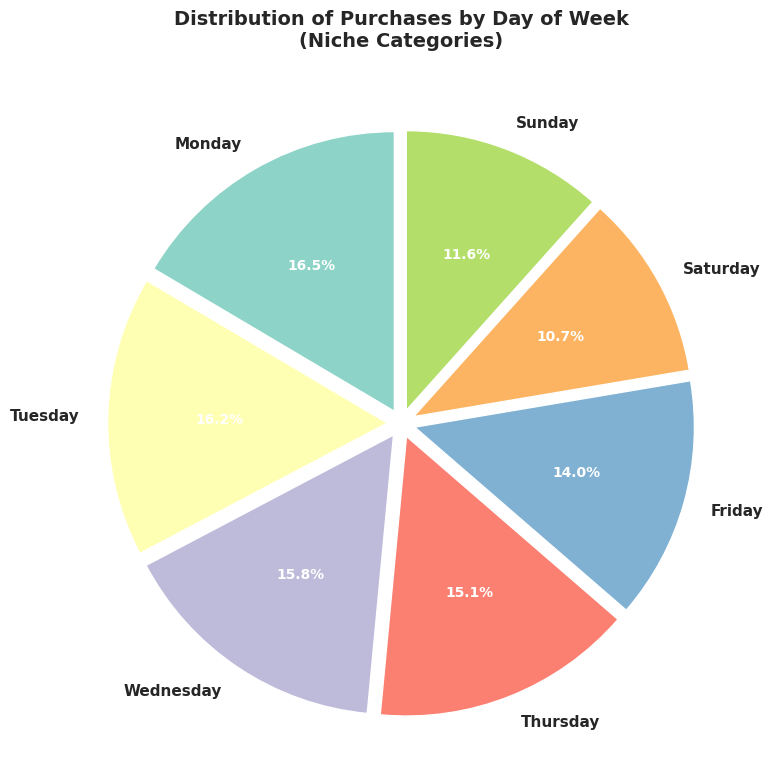

In [31]:
# Create pie chart for purchases by day_of_week
fig, ax = plt.subplots(figsize=(10, 8))

colors = plt.cm.Set3(range(len(day_counts_ordered)))
wedges, texts, autotexts = ax.pie(day_counts_ordered, 
                                    labels=day_counts_ordered.index,
                                    autopct='%1.1f%%',
                                    startangle=90,
                                    colors=colors,
                                    explode=[0.05]*len(day_counts_ordered),
                                    textprops={'fontsize': 11})

# Make percentage text bold
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(10)

# Make labels bold
for text in texts:
    text.set_fontweight('bold')
    text.set_fontsize(11)

ax.set_title('Distribution of Purchases by Day of Week\n(Niche Categories)', 
             fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

Preparing to plot the order per hour for niche product categories based on the same time of day labels as our previous analysis.

In [32]:
# Check the order_purchase_time column format
print("Sample order_purchase_time values:")
print(niche_list['order_purchase_time'].head(10))
print(f"\nData type: {niche_list['order_purchase_time'].dtype}")

Sample order_purchase_time values:
8     18:40:33
10    22:16:10
12    17:04:17
15    20:43:09
18    10:08:57
20    19:48:26
25    00:42:49
32    15:29:43
33    15:29:43
34    15:29:43
Name: order_purchase_time, dtype: object

Data type: object


In [33]:
# Create time_of_day column based on order_purchase_time
def categorize_time_of_day(time_str):
    """Categorize time into different periods of the day"""
    # Extract hour from time string (format: HH:MM:SS)
    hour = int(time_str.split(':')[0])
    
    if 5 <= hour <= 11:
        return 'Morn'
    elif 12 <= hour <= 13:
        return 'Lunch'
    elif 14 <= hour <= 16:
        return 'Aftern'
    elif 17 <= hour <= 18:
        return 'OffWk'
    elif 19 <= hour <= 23:
        return 'Eveng'
    else:  # 0 <= hour <= 4
        return 'WeeHr'

# Apply the function to create new column
niche_list['time_of_day'] = niche_list['order_purchase_time'].apply(categorize_time_of_day)

print("Time of Day Distribution:")
print(niche_list['time_of_day'].value_counts().sort_index())
print(f"\nTotal: {len(niche_list):,}")

Time of Day Distribution:
time_of_day
Aftern     9710
Eveng     13108
Lunch      6029
Morn      10929
OffWk      5733
WeeHr      2173
Name: count, dtype: int64

Total: 47,682


/tmp/ipykernel_102141/74294252.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  niche_list['time_of_day'] = niche_list['order_purchase_time'].apply(categorize_time_of_day)


In [34]:
# Save updated niche_list with time_of_day column to CSV
output_path = db_dir / "niche_list.csv"
niche_list.to_csv(output_path, index=False)
print(f"✓ Updated niche_list saved to: {output_path}")
print(f"  Rows: {len(niche_list):,}")
print(f"  Columns: {len(niche_list.columns)} (includes new 'time_of_day' column)")
print(f"\nColumn names: {list(niche_list.columns)}")

✓ Updated niche_list saved to: meltano-ingestion/db/niche_list.csv
  Rows: 47,682
  Columns: 11 (includes new 'time_of_day' column)

Column names: ['order_id', 'product_id', 'price', 'product_category_name_english', 'order_purchase_timestamp', 'order_purchase_date', 'day_of_week', 'time_of_day', 'order_purchase_time', 'customer_city', 'customer_state']


In [35]:
# Display first few rows of updated niche_list with time_of_day column
niche_list.head()

,order_id,product_id,price,product_category_name_english,order_purchase_timestamp,order_purchase_date,day_of_week,time_of_day,order_purchase_time,customer_city,customer_state
8,0005a1a1728c9d785b8e2b08b904576c,310ae3c140ff94b03219ad0adc3c778f,145.95,health_beauty,2018-03-19 18:40:33,2018-03-19,Monday,OffWk,18:40:33,santos,SP
10,00061f2a7bc09da83e415a52dc8a4af1,d63c1011f49d98b976c352955b1c4bea,59.99,health_beauty,2018-03-24 22:16:10,2018-03-24,Saturday,Eveng,22:16:10,piracicaba,SP
12,0006ec9db01a64e59a68b2c340bf65a7,99a4788cb24856965c36a24e339b6058,74.00,bed_bath_table,2018-07-24 17:04:17,2018-07-24,Tuesday,OffWk,17:04:17,rio de janeiro,RJ
15,0009792311464db532ff765bf7b182ae,8cab8abac59158715e0d70a36c807415,99.90,sports_leisure,2018-08-14 20:43:09,2018-08-14,Tuesday,Eveng,20:43:09,alfenas,MG
18,000c3e6612759851cc3cbb4b83257986,b50c950aba0dcead2c48032a690ce817,99.00,sports_leisure,2017-08-12 10:08:57,2017-08-12,Saturday,Morn,10:08:57,jundiai,SP


In [36]:
# Calculate orders per hour for each time_of_day period
time_of_day_counts = niche_list['time_of_day'].value_counts()

# Define hours for each time period
time_periods = {
    'Morn': {'hours': 7, 'range': '05:00-11:59'},    # 5-11 = 7 hours
    'Lunch': {'hours': 2, 'range': '12:00-13:59'},   # 12-13 = 2 hours
    'Aftern': {'hours': 3, 'range': '14:00-16:59'},  # 14-16 = 3 hours
    'OffWk': {'hours': 2, 'range': '17:00-18:59'},   # 17-18 = 2 hours
    'Eveng': {'hours': 5, 'range': '19:00-23:59'},   # 19-23 = 5 hours
    'WeeHr': {'hours': 5, 'range': '00:00-04:59'}    # 0-4 = 5 hours
}

# Calculate orders per hour for each period
orders_per_hour = {}
for period, info in time_periods.items():
    if period in time_of_day_counts:
        orders_per_hour[period] = {
            'orders': time_of_day_counts[period],
            'hours': info['hours'],
            'range': info['range'],
            'orders_per_hour': time_of_day_counts[period] / info['hours']
        }

# Display the data
print("Orders Per Hour by Time of Day:")
print("-" * 70)
for period in ['Morn', 'Lunch', 'Aftern', 'OffWk', 'Eveng', 'WeeHr']:
    data = orders_per_hour[period]
    print(f"{period:8} ({data['range']:13}) | {data['hours']} hrs | {data['orders']:5,} orders | {data['orders_per_hour']:7.1f} orders/hr")
print("-" * 70)

Orders Per Hour by Time of Day:
----------------------------------------------------------------------
Morn     (05:00-11:59  ) | 7 hrs | 10,929 orders |  1561.3 orders/hr
Lunch    (12:00-13:59  ) | 2 hrs | 6,029 orders |  3014.5 orders/hr
Aftern   (14:00-16:59  ) | 3 hrs | 9,710 orders |  3236.7 orders/hr
OffWk    (17:00-18:59  ) | 2 hrs | 5,733 orders |  2866.5 orders/hr
Eveng    (19:00-23:59  ) | 5 hrs | 13,108 orders |  2621.6 orders/hr
WeeHr    (00:00-04:59  ) | 5 hrs | 2,173 orders |   434.6 orders/hr
----------------------------------------------------------------------


Plot the pie chart of order per hour at different time of the day. The results are largely simiilar to the findings from the full order data.

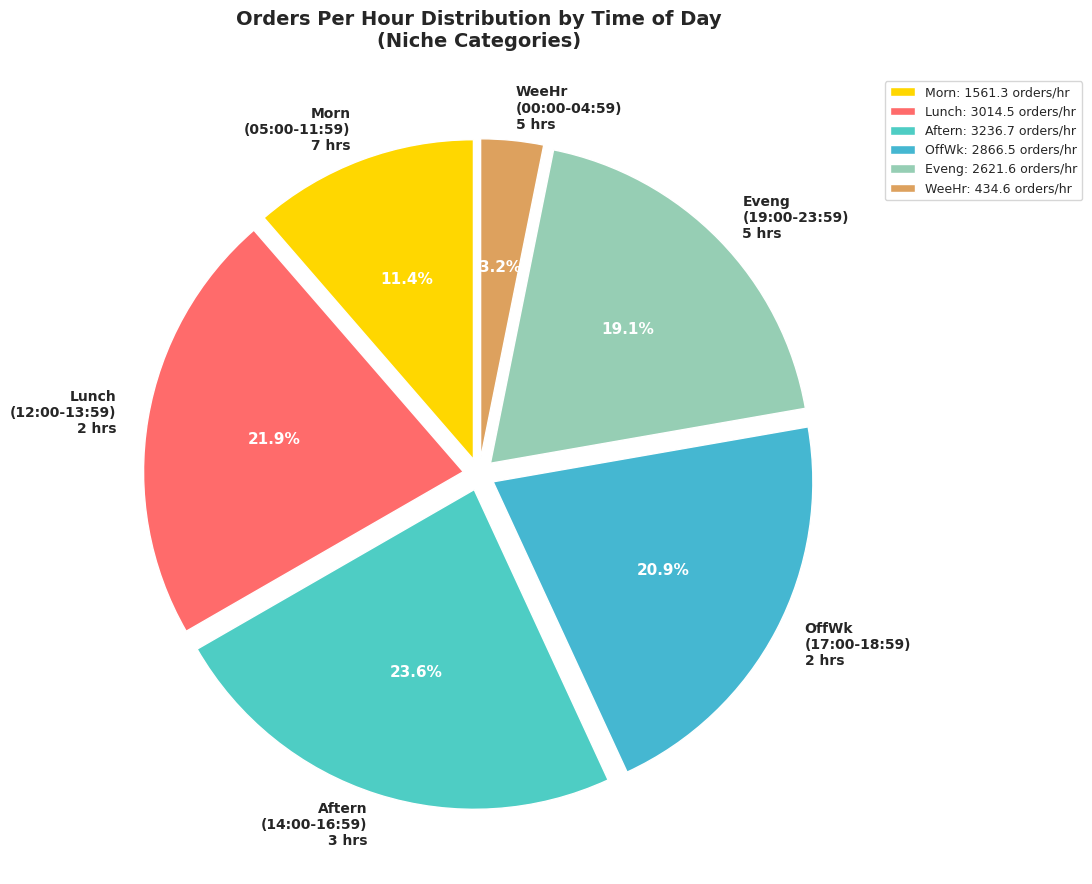

In [37]:
# Prepare data for pie chart
period_order = ['Morn', 'Lunch', 'Aftern', 'OffWk', 'Eveng', 'WeeHr']
values = [orders_per_hour[p]['orders_per_hour'] for p in period_order]
labels_with_hours = [f"{p}\n({orders_per_hour[p]['range']})\n{orders_per_hour[p]['hours']} hrs" 
                     for p in period_order]

# Create pie chart
fig, ax = plt.subplots(figsize=(12, 9))

colors = ['#FFD700', '#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#DDA15E']
wedges, texts, autotexts = ax.pie(values, 
                                    labels=labels_with_hours,
                                    autopct='%1.1f%%',
                                    startangle=90,
                                    colors=colors,
                                    explode=[0.05]*len(values),
                                    textprops={'fontsize': 10})

# Make percentage text bold and white
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)

# Make labels bold
for text in texts:
    text.set_fontweight('bold')
    text.set_fontsize(10)

ax.set_title('Orders Per Hour Distribution by Time of Day\n(Niche Categories)', 
             fontsize=14, fontweight='bold', pad=20)

# Add a legend with orders/hour values
legend_labels = [f"{p}: {orders_per_hour[p]['orders_per_hour']:.1f} orders/hr" 
                 for p in period_order]
ax.legend(legend_labels, loc='upper left', bbox_to_anchor=(1, 1), fontsize=9)

plt.tight_layout()
plt.show()

Preparing to plot stacked bar chart of the top 10 cities making orders of niche products.

In [40]:
# Calculate total spending by city and get top 10
city_spending = niche_list.groupby(['customer_city', 'customer_state'])['price'].sum().reset_index()
city_spending.columns = ['city', 'state', 'total_spending']
city_spending = city_spending.sort_values('total_spending', ascending=False).head(10)

print("Top 10 Cities by Total Spending:")
print(city_spending.to_string(index=False))
print(f"\nTotal: ${city_spending['total_spending'].sum():,.2f}")

Top 10 Cities by Total Spending:
          city state  total_spending
     sao paulo    SP       894257.34
rio de janeiro    RJ       429917.37
belo horizonte    MG       157677.41
      brasilia    DF       154577.74
      curitiba    PR        99660.33
      salvador    BA        96829.08
      campinas    SP        89444.25
  porto alegre    RS        79670.05
     guarulhos    SP        72259.74
       niteroi    RJ        57119.55

Total: $2,131,412.86


In [41]:
# Get spending by category for each of the top 10 cities
top10_cities = city_spending['city'].tolist()

# Filter niche_list for top 10 cities and create pivot table
city_category_spending = niche_list[niche_list['customer_city'].isin(top10_cities)].groupby(
    ['customer_city', 'product_category_name_english']
)['price'].sum().unstack(fill_value=0)

# Reorder to match top 10 cities order
city_category_spending = city_category_spending.reindex(top10_cities)

print("Spending by Category for Top 10 Cities:")
print(city_category_spending)
print(f"\nCategories: {list(city_category_spending.columns)}")

Spending by Category for Top 10 Cities:
product_category_name_english      auto  bed_bath_table  computers  \
customer_city                                                        
sao paulo                      58354.08       170705.41   20769.58   
rio de janeiro                 28162.13        77871.29    8737.49   
belo horizonte                 16081.01        31974.78    2036.00   
brasilia                       17290.04        16120.81   10786.99   
curitiba                        8267.23        13026.83    3639.99   
salvador                       10207.67        10131.42    6698.00   
campinas                        8596.18        16688.63    1899.00   
porto alegre                    3641.80        17400.47    1798.90   
guarulhos                       8949.52        12764.48    3526.99   
niteroi                         3020.93         7596.57    1437.00   

product_category_name_english  computers_accessories  health_beauty  \
customer_city                                   

Plot the stacked bar chart for the top 10 cities ordering niche products.

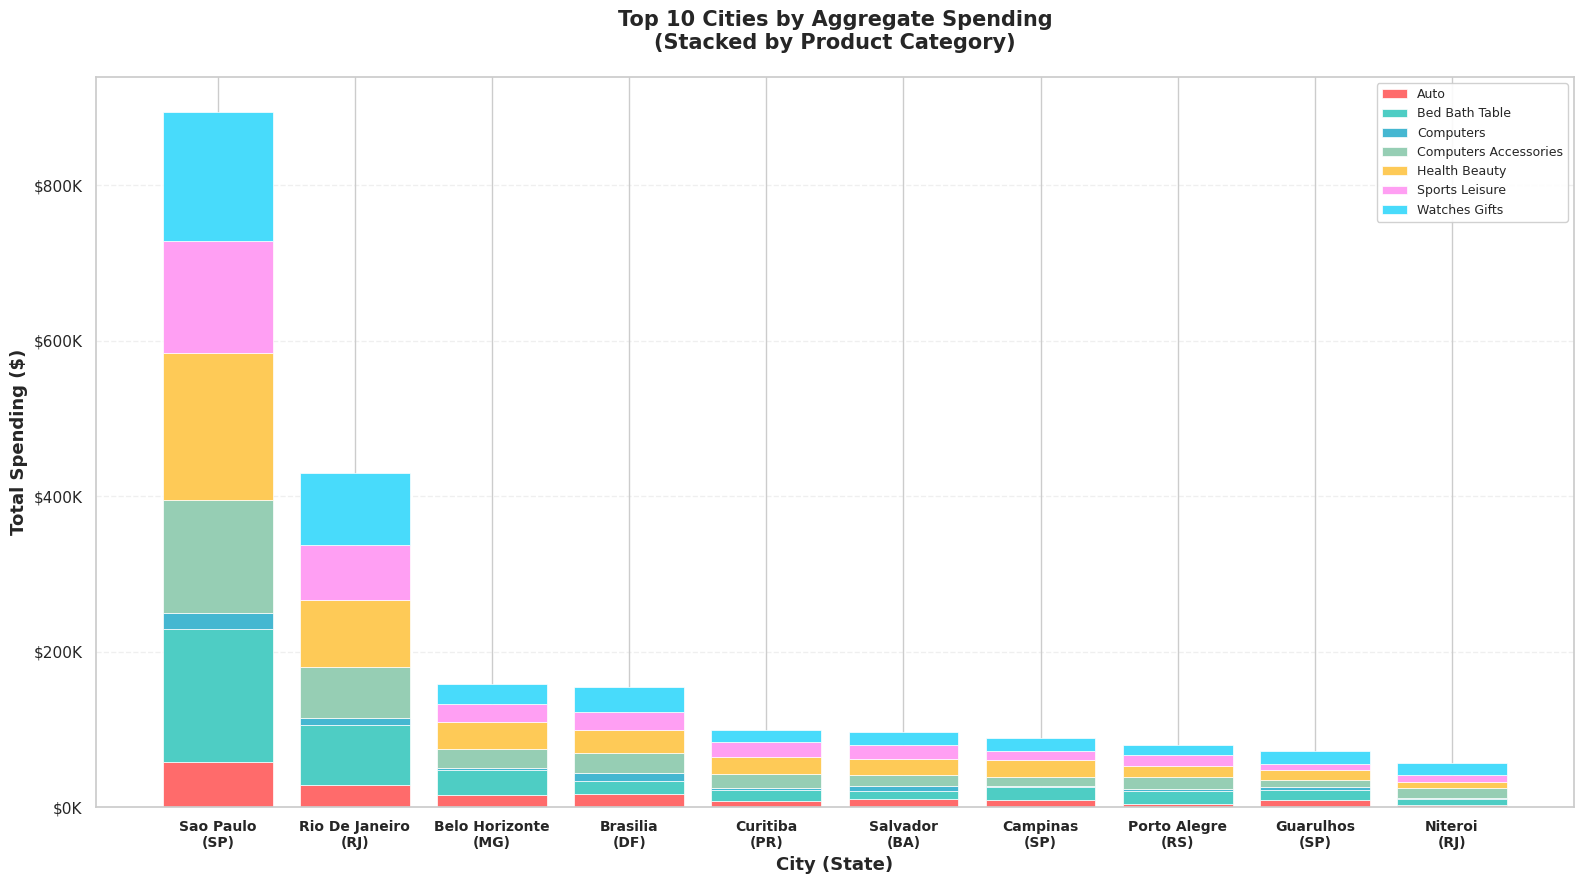

In [42]:
# Create city labels with state information
city_labels = [f"{city.title()}\n({city_spending[city_spending['city'] == city]['state'].values[0]})" 
               for city in top10_cities]

# Create stacked bar chart
fig, ax = plt.subplots(figsize=(16, 9))

# Define colors for each category
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57', '#FF9FF3', '#48DBFB']

# Create stacked bars
bottom = np.zeros(len(top10_cities))
for idx, category in enumerate(city_category_spending.columns):
    values = city_category_spending[category].values
    ax.bar(range(len(top10_cities)), values, bottom=bottom, 
           label=category.replace('_', ' ').title(), 
           color=colors[idx % len(colors)],
           edgecolor='white',
           linewidth=0.5)
    bottom += values

# Formatting
ax.set_xlabel('City (State)', fontsize=13, fontweight='bold')
ax.set_ylabel('Total Spending ($)', fontsize=13, fontweight='bold')
ax.set_title('Top 10 Cities by Aggregate Spending\n(Stacked by Product Category)', 
             fontsize=15, fontweight='bold', pad=20)
ax.set_xticks(range(len(top10_cities)))
ax.set_xticklabels(city_labels, fontsize=10, fontweight='bold')

# Add grid
ax.yaxis.grid(True, alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Format y-axis to show currency
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# Add legend
ax.legend(loc='upper right', fontsize=9, framealpha=0.9, ncol=1)

plt.tight_layout()
plt.show()